# Data Cleaning Jupyter Notebook
## Objectives
- Evaluate missing data
- Clean data

### Importing necessary libraries

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Retail-Sales-Prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Retail-Sales-Prediction'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps

### Loading the data

In [5]:
data_path = "outputs/merged_data.csv"
df = pd.read_csv(data_path)

### Change "Store" and "Dept" to object (categorical) and "Date" to datetime

In [6]:
df['Store'] = df['Store'].astype('object')
df['Dept'] = df['Dept'].astype('object')
df['Date'] = pd.to_datetime(df['Date'])

/workspace/.pip-modules/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/01/2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/workspace/.pip-modules/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/04/2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/workspace/.pip-modules/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/05/2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/workspace/.pip-modules/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/07/2012' in DD/MM/Y

### Dropping rows where "Weekly_Sales" is missing

In [7]:
df = df.dropna(subset=['Weekly_Sales'])

### Data Exploration - Show columns with missing values

In [8]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64


### Visualize missing values using a heatmap

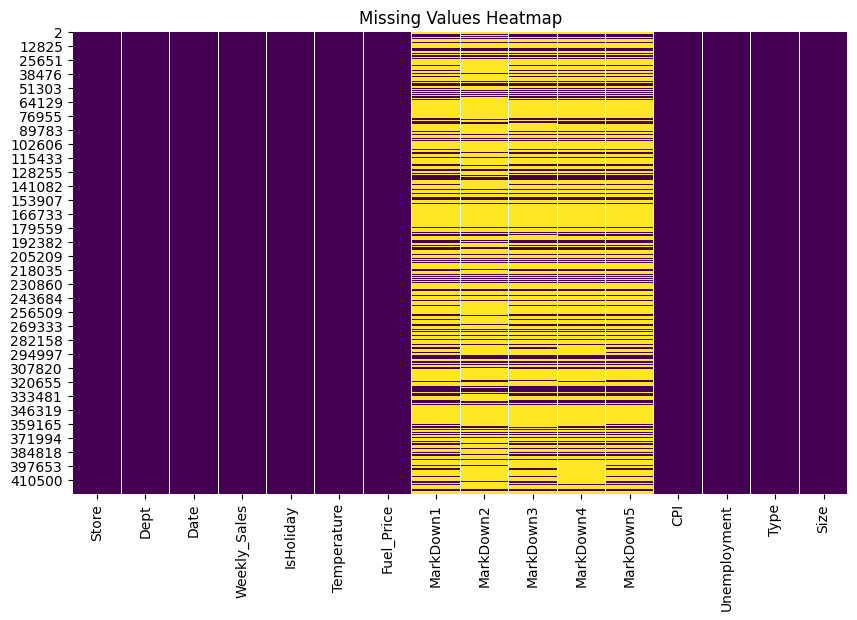

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### Correlation and Power Predictive Score (PPS) Analysis

In [10]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:

        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')

        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(
        columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query(
        "ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi collinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold,
                 figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold,
                 figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold,
                figsize=figsize, font_annot=font_annot)

In [11]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  237.0  0.305  0.347  0.0  0.0  0.094  0.687  0.947




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi collinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



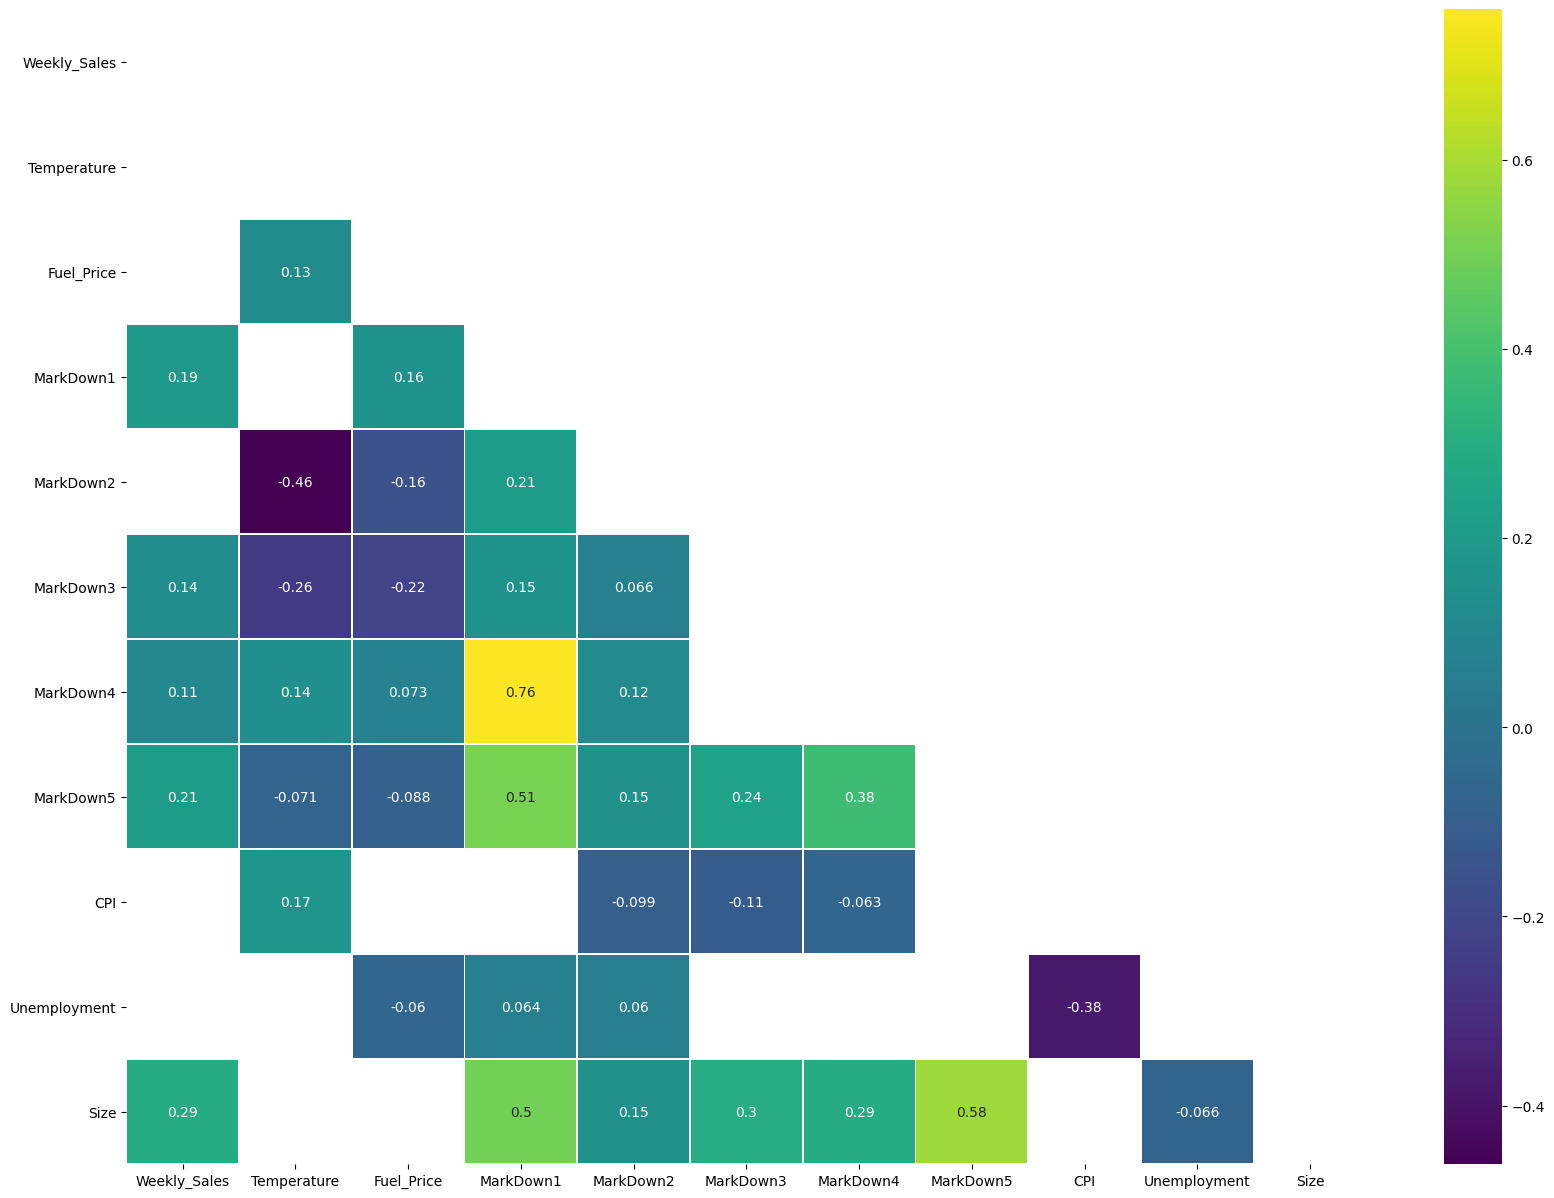



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



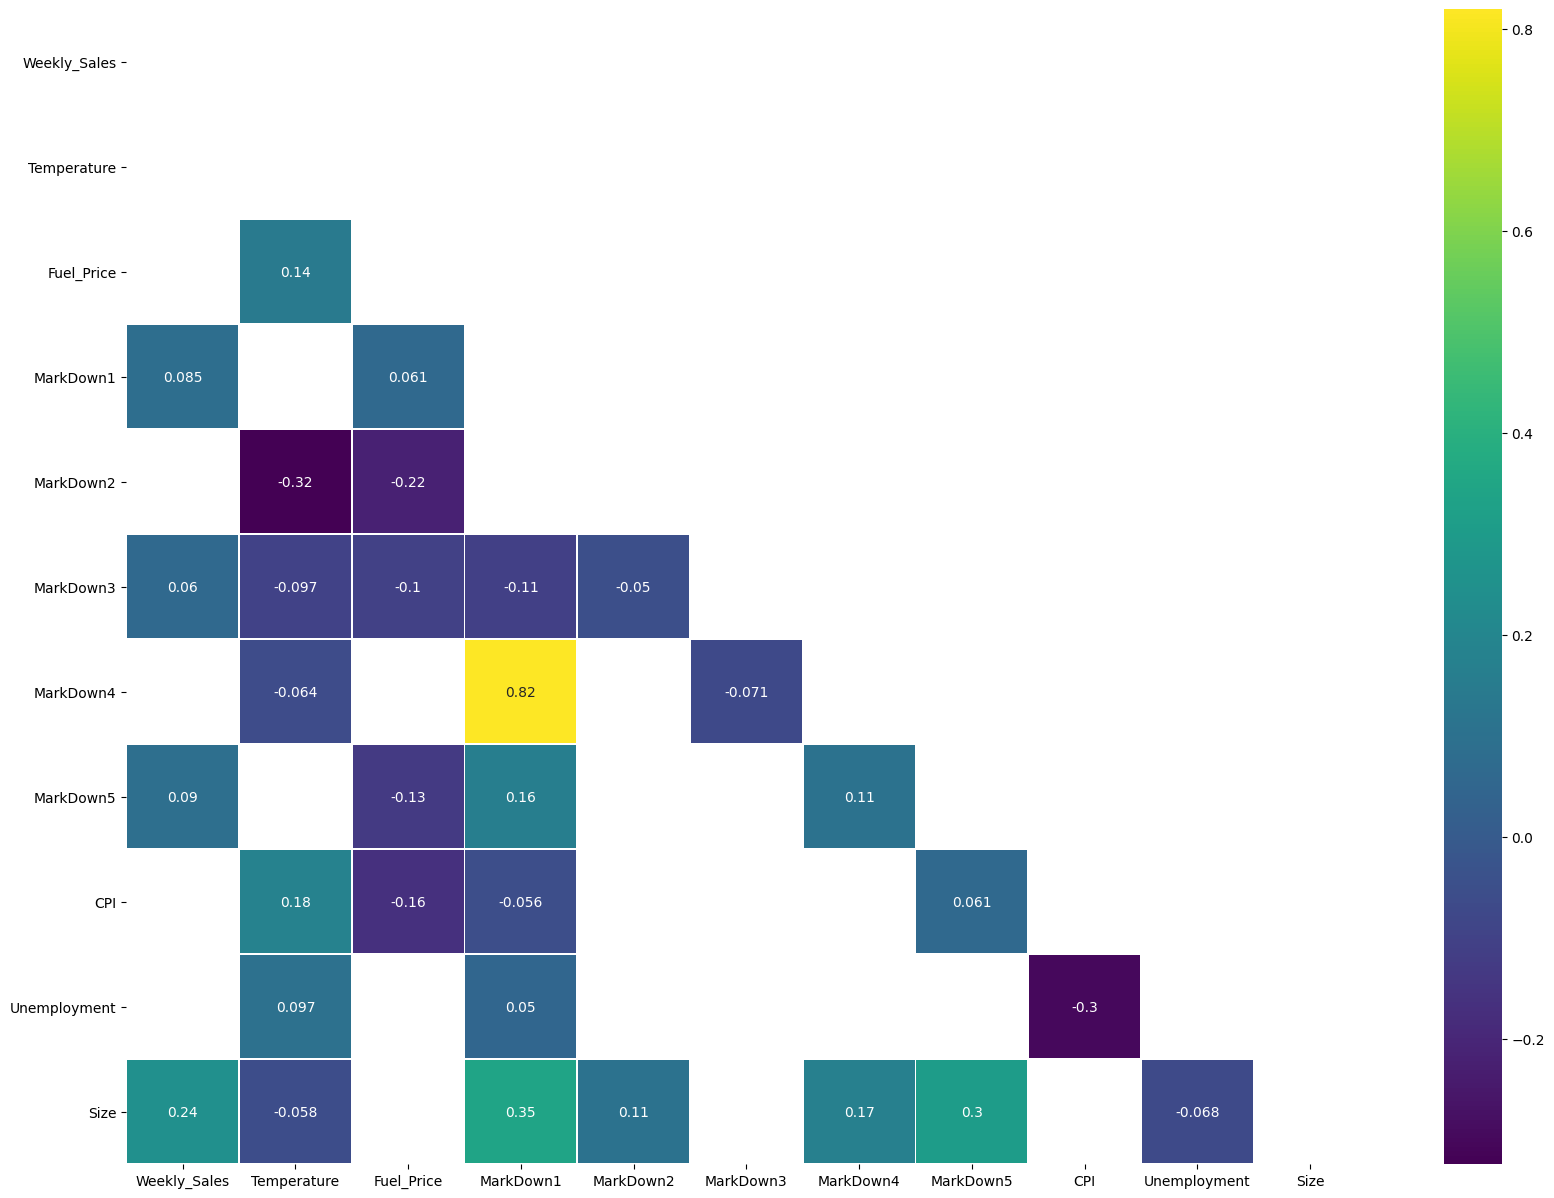



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



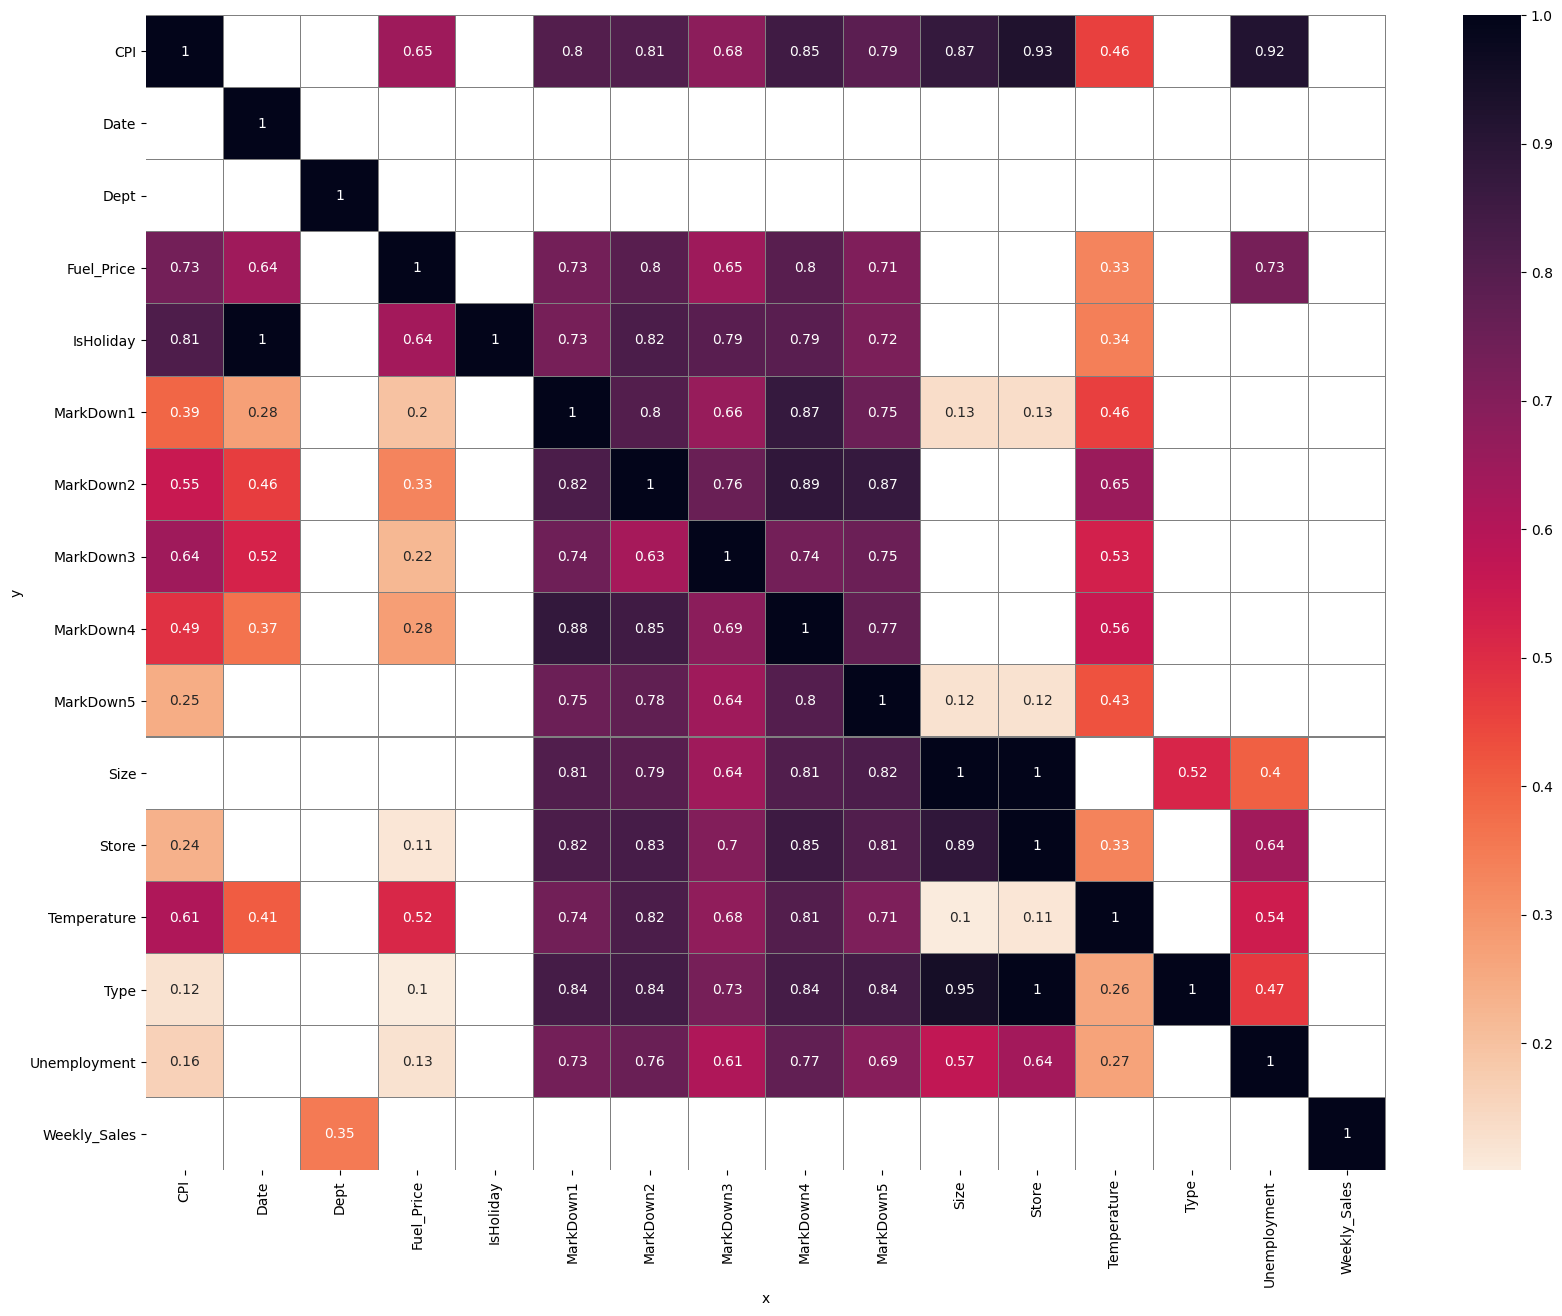

In [12]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman,
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.05, PPS_Threshold=0.1,
                  figsize=(20, 15), font_annot=10)

### Data Cleaning - Assessing Missing Data Levels
Calculating missing percentage for each column

In [13]:
missing_percentage = df.isnull().mean() * 100
print("Missing Percentage per Column:\n", missing_percentage)

Missing Percentage per Column:
 Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64


### Dealing with Missing Data

### Impute 0 for missing/negative "Weekly_Sales" and all 5 MarkDowns

In [14]:
df['Weekly_Sales'] = df['Weekly_Sales'].apply(lambda x: x if x > 0 else 0)

In [15]:
for markdown in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    df[markdown] = df[markdown].fillna(0)

### Impute median for missing "Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"

In [16]:
for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

### Impute Most frequent level for missing "Type" and "IsHoliday"

In [17]:
df['Type'] = df['Type'].fillna(df['Type'].mode()[0])
df['IsHoliday'] = df['IsHoliday'].fillna(df['IsHoliday'].mode()[0])

### Impute 46 for missing "Store"

In [18]:
df['Store'] = df['Store'].fillna('46')

### Impute 100 for missing "Dept"

In [19]:
df['Dept'] = df['Dept'].fillna('100')

### Push the cleaned data to Repo (outputs folder)

In [20]:
df['Store'] = df['Store'].astype('object')
df['Dept'] = df['Dept'].astype('object')
output_path = "outputs/Cleaned.csv"
df.to_csv(output_path, index=False)
print(f"Cleaned data saved to {output_path}")

Cleaned data saved to outputs/Cleaned.csv
